# MSE for \mu


Calculating corrected MSE...


Computing MSE: 100%|██████████| 200/200 [00:00<00:00, 2736.12it/s]


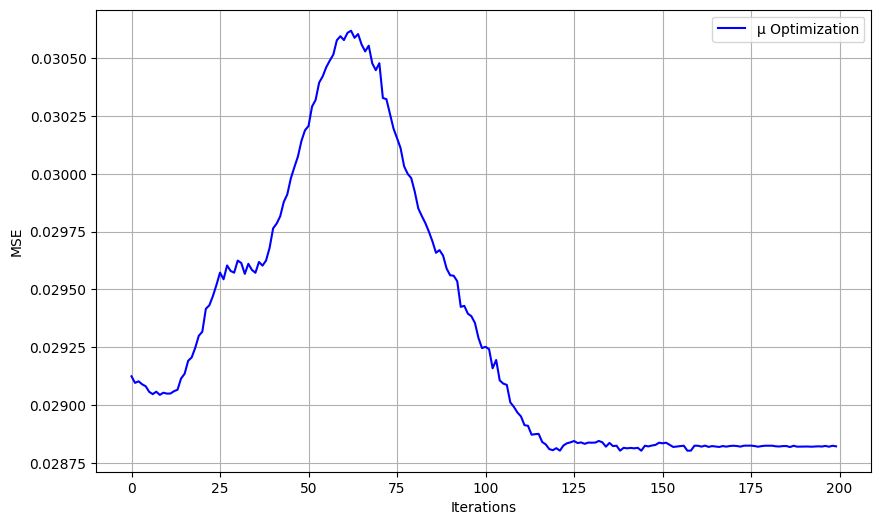

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import strawberryfields as sf


# --- Parameters ---
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
eta, delta = 0.9, 0.01  # Channel parameters
epsilon_init = 10  # Fixed squeezing in dB

# --- Helper Functions ---
def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    #  approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg
    

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution P(x_mu) after phase rotation."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]
    
    # Rotate quadratures by phi (LO phase μ)
    X = Q * np.cos(phi) + P * np.sin(phi)
    
    # Bin rotated values
    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))
    
    # Compute histogram
    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))
    
    # Normalize
    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu

def compute_marginal_mse(phi_values):
    """Compute MSE between ideal and μ-optimized marginals."""
    mse_values = []
    
    # Precompute states once (no μ in state preparation)
    W_ideal = prepare_gkp_state(
        epsilon=db_to_epsilon(epsilon_init),
        eta=1.0,
        gamma=0.0  # No noise for ideal state
    )
    W_noisy = prepare_gkp_state(
        epsilon=db_to_epsilon(epsilon_init),
        eta=eta,
        gamma=delta  # Apply noise to noisy state
    )

    for phi in tqdm(phi_values, desc="Computing MSE"):
        # Apply μ during MEASUREMENT (not state preparation)
        P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=phi)  # Ideal measured at μ=0
        P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=phi)   # Noisy measured at μ
        # Calculate MSE between distributions
        mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
        mse_values.append(mse)
    
    return mse_values

# --- Main Execution ---
if __name__ == "__main__":
    # Load optimization history

    filename_mu_simul1 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_10_new.txt"
    mu_data1 = np.loadtxt(filename_mu_simul1)
    mu_history1 = mu_data1[:, 1]

    print("Calculating corrected MSE...")
    mse_mu_new1 = compute_marginal_mse(mu_history1)
 
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(mse_mu_new1, label='μ Optimization', color='blue', markersize=4)
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
import numpy as np

# x-axis from -6 to +6 with 5 points (small example)
quad_axis_small = np.linspace(-6, 6, 5)  

P_ideal_small  = np.array([0.0, 0.1, 0.5, 0.3, 0.1])
P_noisy_small  = np.array([0.0, 0.1, 0.4, 0.4, 0.1])

difference_sq = (P_noisy_small - P_ideal_small)**2  
# [0.   0.   0.01 0.01 0.  ]

# Now integrate:
mse_value = np.trapz(difference_sq, quad_axis_small)
print("MSE =", mse_value)

MSE = 0.06000000000000001
